In [1]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from utils.utils import load_disc_model
from utils.discrim_training import HideAttackExp
from utils.data import load_Ford_A, transform_data, MyDataset
from models.models import LSTM_net
from utils.estimation import plot_aa_metrics

from utils.attacks import fgsm_disc_attack, fgsm_attack, fgsm_reg_attack

# Functions

In [2]:
def load_data(name, path='results/Ford_A/Regular_Disc/Same_disc/', dataset='Ford_A' , model_id=0):

    df_all = pd.DataFrame()

    if 'original' not in name:
        for alpha in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
            try:
                
                df_loc = pd.read_csv(path + f'aa_res_{dataset}_{model_id}_alpha={alpha}.csv', index_col=0)
                df_loc['method_attack'] = name
                df_loc['alpha'] = alpha
                df_all = pd.concat([df_all, df_loc])
            except:
                print('Fail with Alpha', alpha, name)


    else:
        df_all = pd.read_csv(path + f'aa_res_{dataset}_{model_id}.csv', index_col=0)
        df_all['method_attack'] = 'original'
        df_all['alpha'] = 0

    return df_all

def load_all_datasets(dict_name_path, dataset='Ford_A'):

    df_all = pd.DataFrame([])

    for name, (path, id) in dict_name_path.items():
        df_loc = load_data(name, path, dataset, id)
        df_all = pd.concat([df_all, df_loc])

    return df_all


In [3]:
def plot_attack(models_for_viz, style, alpha, eps, dataset='Ford_A', metrics=['ACC', 'HID']):
    
    if isinstance(alpha, float) or isinstance(alpha, int):
        alpha_dict = dict()
        for key in models_for_viz:
            alpha_dict[key] = alpha
        alpha = alpha_dict

    if isinstance(eps, float) or isinstance(eps, int):
        eps_dict = dict()
        for key in models_for_viz:
            eps_dict[key] = eps
        eps = eps_dict
    
    df_res = load_all_datasets(models_for_viz, dataset=dataset)
    df_res['eps'] = df_res['eps'].round(4)

    plt.figure(figsize=(5*len(metrics) + 3, 7))
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i+1)
        metric_name = 'effectiveness (accuracy)' if metric == 'ACC' else 'simplicity of detection'
        plt.title(metric_name)
        for method_attack in df_res['method_attack'].unique():
            if method_attack not in style:
                continue
            mask = (df_res['method_attack'] == method_attack) & \
                (df_res['eps'] == eps[method_attack]) & \
                (df_res['alpha'].isin([0, alpha[method_attack]]))
            
            df_filter_viz = df_res[mask]
            plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack, 
                    **style[method_attack])

        plt.xlabel('steps of attack')
        plt.ylabel('metric')
        plt.legend()
        plt.grid()
    plt.show()

# Discriminator model

In [37]:
def load_experiment(model_name='fgsm_attack_eps=0.03_nsteps=10', device='cpu'):
    with open(fr'results/Ford_A/IFGSM/Regular/Discriminator_pickle/{model_name}/0.pickle', 'rb') as f:
        experiment = pickle.load(f)

    return experiment

In [38]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
experiment = load_experiment(model_name='fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10', device=device)

FileNotFoundError: [Errno 2] No such file or directory: 'results/Ford_A/IFGSM/Regular/Discriminator_pickle/fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10/0.pickle'

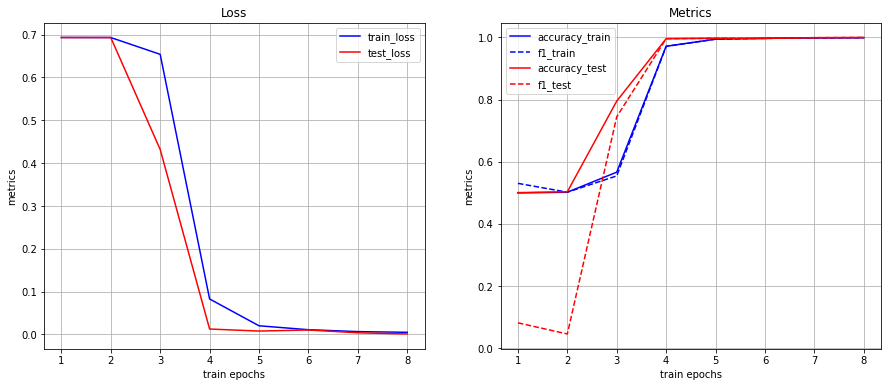

In [ ]:
train_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['train']['loss']][:8]
test_loss = [el.cpu().detach().numpy() for el in experiment.dict_logging['test']['loss']][:8]

train_accuracy = experiment.dict_logging['train']['accuracy'][:8]
train_f1 = experiment.dict_logging['train']['f1'][:8]
test_accuracy = experiment.dict_logging['test']['accuracy'][:8]
test_f1 = experiment.dict_logging['test']['f1'][:8]

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot(np.arange(len(test_accuracy))+1, train_loss, c='blue', label ='train_loss')
plt.plot(np.arange(len(test_accuracy))+1, test_loss, c='red', label ='test_loss')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.subplot(1, 2, 2)
plt.title("Metrics")

plt.plot(np.arange(len(train_accuracy))+1, train_accuracy, c='blue', label ='accuracy_train')
plt.plot(np.arange(len(train_accuracy))+1, train_f1, c='blue', linestyle='--', label ='f1_train')
plt.plot(np.arange(len(test_accuracy))+1, test_accuracy, c='red', label ='accuracy_test')
plt.plot(np.arange(len(test_accuracy))+1, test_f1, c='red', linestyle='--', label ='f1_test')
plt.grid()
plt.legend()
plt.xlabel('train epochs')
plt.ylabel('metrics')


plt.show()

# Reg attack analysis

In [4]:
df_loc_test = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/TEST_aa_res_Ford_A_0_alpha=1.csv', index_col=0)
df_loc_orig = pd.read_csv(f'results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/aa_res_Ford_A_0_alpha=1.csv', index_col=0)

In [5]:
models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_diff': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_many_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_many_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2/', 0),
    'ITER_2_BIG_ALPHA':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'iter_mix_3': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_iters_3/', 0),
    'iter_mix_2': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2/', 0),
    'iter_mix_2_big': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    'iter_mix_2_12': ('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_12/', 0),
    'reg_disc_diff_many_4_id_1':('results/Ford_A/IFGSM/Disc_reg_model_id_1/', 1),
    'Many':('results/Ford_A/IFGSM/Disc_reg_10/', 0),
    'DeepFool':('results/Ford_A/DeepFool/Original/', 0),
    }

df_res = load_all_datasets(models_for_viz)
df_res['eps'] = df_res['eps'].round(4)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc_diff
Fail with Alpha 0 reg_disc_diff_another
Fail with Alpha 0 reg_disc_diff_many_2
Fail with Alpha 0 reg_disc_diff_many_4
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_2_BIG_ALPHA
Fail with Alpha 0.001 ITER_2_BIG_ALPHA
Fail with Alpha 0.01 ITER_2_BIG_ALPHA
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 iter_mix_3
Fail with Alpha 0.001 iter_mix_3
Fail with Alpha 0.01 iter_mix_3
Fail with Alpha 100 iter_mix_3
Fail with Alpha 0 iter_mix_2
Fail with Alpha 0.001 iter_mix_2
Fail with Alpha 0.01 iter_mix_2
Fail with Alpha 0.1 iter_mix_2
Fail with Alpha 100 iter_mix_2
Fail with Alpha 0 iter_mix_2_big
Fail with Alpha 0.001 iter_mix_2_big
Fail with Alpha 0.01 iter_mix_2_big
Fail with Alpha 0 iter_mix_2_12
Fail with Alpha 0.001 iter_mix_2_12
Fail with Alpha 0.01 iter_mix_2_12
Fail with Alpha 0 reg_di

In [6]:
#df_res['eps'].unique()

In [7]:
#df_res['method_attack'].unique()

In [8]:
alpha = 10
eps = df_res.eps.unique()[1]

print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]

eps:  0.0056


In [9]:
style ={
    'original':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_neigh':  {'linestyle':'solid', 'linewidth':1.5, 'color':'orange'},
    'reg_disc_same':  {'linestyle':'dotted', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    #'reg_disc_diff_many_2': {'linestyle':'solid', 'linewidth':1.5, 'color':'black'},
    'reg_disc_diff_many_4': {'linestyle':'dashed', 'linewidth':1.0,},
    'ITER_2': {'linestyle':'dashdot', 'linewidth':1.0, 'color':'green'},
    'ITER_2_BIG_ALPHA': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'green'},
    'ITER_3': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'blue'},
    'iter_mix_3': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'grey'},
    'iter_mix_2': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'black'},
    'iter_mix_2_big': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'red'},
    'iter_mix_2_12': {'linestyle':'dashdot', 'linewidth':1.5, 'color':'purple'},
    'reg_disc_diff_many_4_id_1': {'linestyle':'dashed', 'linewidth':1.0, },
    'Many': {'linestyle':'solid', 'linewidth':1.5, 'color':'grey'},
    'DeepFool': {'linestyle':'dashed', 'linewidth':1.5, },
    
}

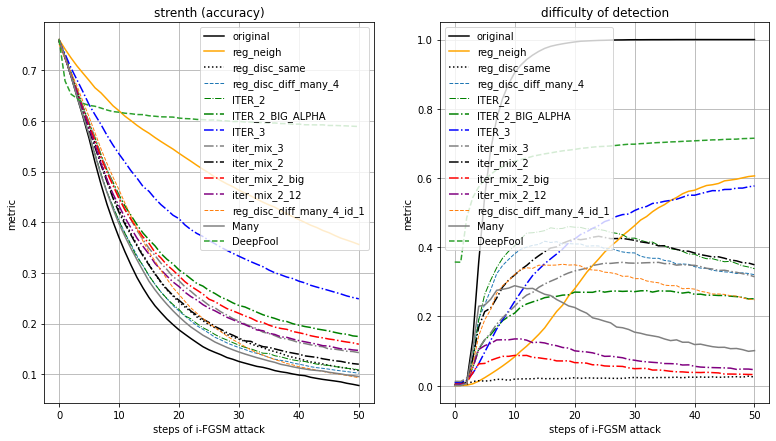

In [10]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    metric_name = 'strenth (accuracy)' if metric == 'ACC' else 'difficulty of detection'
    plt.title(metric_name)
    for method_attack in df_filter['method_attack'].unique():
        if method_attack not in style:
            continue
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack, 
                 **style[method_attack])

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


### viz_mode

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 reg_disc_diff
Fail with Alpha 0 reg_disc_diff_another
Fail with Alpha 0 reg_disc_diff_many_2
Fail with Alpha 0 reg_disc_diff_many_4


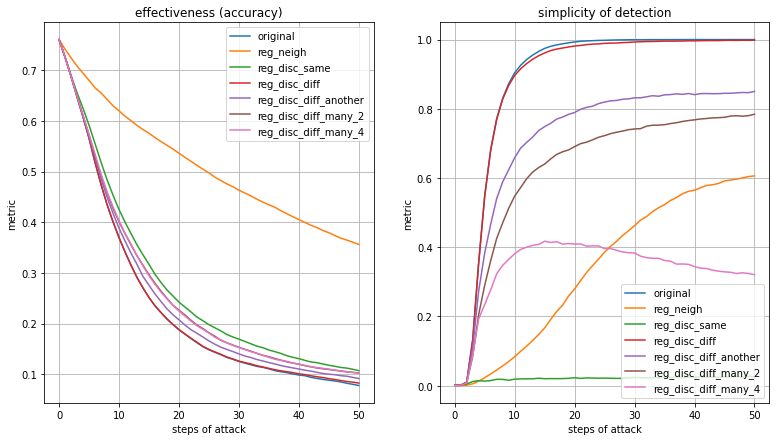

In [11]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'reg_disc_diff': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'reg_disc_diff_another': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_2/', 0),
    'reg_disc_diff_many_2':('results/Ford_A/IFGSM/Regular_Disc/Diff_disc_many/', 0),
    'reg_disc_diff_many_4':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    }


style ={
    'original':  {'linestyle':'solid', 'linewidth':1.5,},
    'reg_neigh':  {'linestyle':'solid', 'linewidth':1.5},
    'reg_disc_same':  {'linestyle':'solid', 'linewidth':1.5,},
    'reg_disc_diff':  {'linestyle':'solid', 'linewidth':1.5, },
    'reg_disc_diff_another':  {'linestyle':'solid', 'linewidth':1.5, },
    'reg_disc_diff_many_2': {'linestyle':'solid', 'linewidth':1.5, },
    'reg_disc_diff_many_4': {'linestyle':'solid', 'linewidth':1.5,},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

Fail with Alpha 0 IFGSM
Fail with Alpha 0.001 IFGSM
Fail with Alpha 100 IFGSM
Fail with Alpha 0.001 SimBA
Fail with Alpha 0.01 SimBA
Fail with Alpha 0.1 SimBA
Fail with Alpha 1 SimBA
Fail with Alpha 10 SimBA
Fail with Alpha 100 SimBA
Fail with Alpha 0.001 DeepFool
Fail with Alpha 0.01 DeepFool


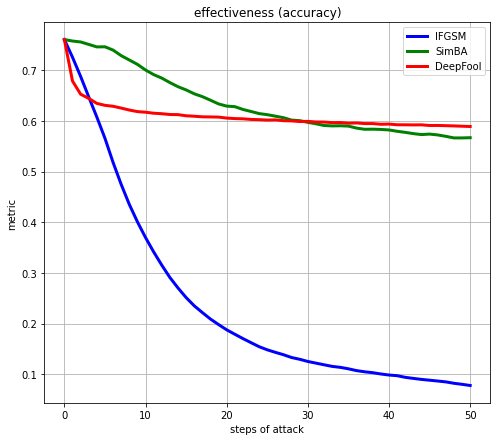

In [12]:
alpha = 10
eps = {
    'IFGSM': 0.0056,
    'SimBA':  0.1778,
    'DeepFool':  0.1778
}
metrics=['ACC']

models_for_viz = {
    'IFGSM': ('results/Ford_A/IFGSM/Original/', 0),
    'SimBA': ('results/Ford_A/SimBA/Original/', 0),
    'DeepFool': ('results/Ford_A/DeepFool/Original/', 0),
    }


style ={
    'IFGSM': {'linestyle':'solid', 'linewidth':3.0, 'color':'blue'},
    'SimBA': {'linestyle':'solid', 'linewidth':3.0, 'color':'green'},
    'DeepFool': {'linestyle':'solid', 'linewidth':3.0, 'color':'red'},
}



plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, metrics=metrics)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 ITER_1
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 Many
Fail with Alpha 0.001 Many
Fail with Alpha 0.01 Many


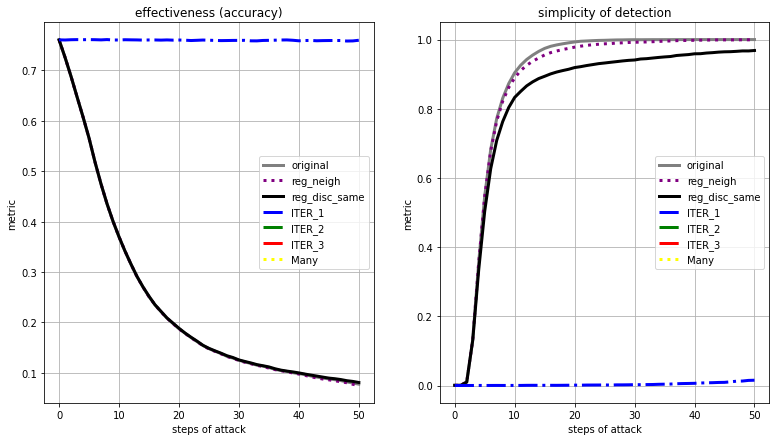

In [13]:
alpha = 0.1
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'ITER_1':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'Many':('results/Ford_A/IFGSM/Disc_reg_10/', 0)
    }


style ={
    'original': {'linestyle':'solid', 'linewidth':3.0, 'color':'grey'},
    'reg_neigh': {'linestyle':'dotted', 'linewidth':3.0, 'color':'purple'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':3.0, 'color':'black'},
    'ITER_1':{'linestyle':'dashdot', 'linewidth':3.0, 'color':'blue'},
    'ITER_2':{'linestyle':'dashdot', 'linewidth':3.0, 'color':'green'},
    'ITER_3':{'linestyle':'dashdot', 'linewidth':3.0, 'color':'red'},
    'Many' : {'linestyle':'dotted', 'linewidth':3.0, 'color':'yellow'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0 ITER_1
Fail with Alpha 0 ITER_2
Fail with Alpha 0.001 ITER_2
Fail with Alpha 0.01 ITER_2
Fail with Alpha 0 ITER_3
Fail with Alpha 0.001 ITER_3
Fail with Alpha 0.01 ITER_3
Fail with Alpha 0 ITER_ALL
Fail with Alpha 0.001 ITER_ALL
Fail with Alpha 0.01 ITER_ALL
Fail with Alpha 0 Many
Fail with Alpha 0.001 Many
Fail with Alpha 0.01 Many


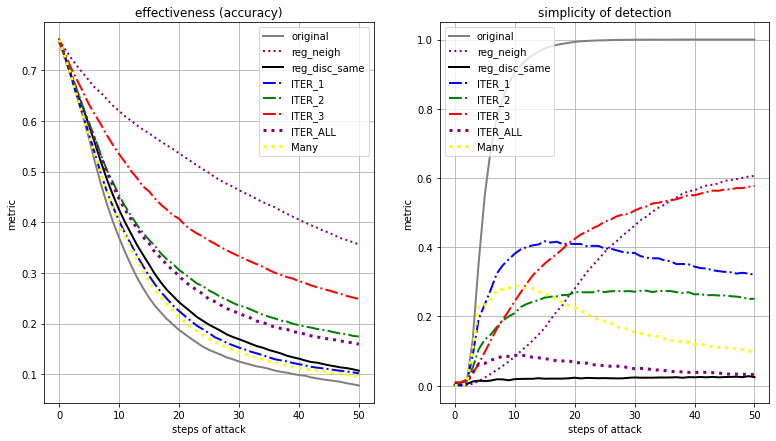

In [14]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]


models_for_viz = {
    'original': ('results/Ford_A/IFGSM/Original/', 0),
    'reg_neigh': ('results/Ford_A/IFGSM/Regular/', 0),
    'reg_disc_same': ('results/Ford_A/IFGSM/Regular_Disc/Same_disc/', 0),
    'ITER_1':('results/Ford_A/IFGSM/Regular_Disc/Diff_many_4/', 0),
    'ITER_2':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_2_BIG_ALPHA/', 0),
    'ITER_3':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_iter_3/', 0),
    'ITER_ALL':('results/Ford_A/IFGSM/Regular_Disc/Disc_reg_mixed_2_big/', 0),
    'Many':('results/Ford_A/IFGSM/Disc_reg_10/', 0)
    }


style ={
    'original': {'linestyle':'solid', 'linewidth':2.0, 'color':'grey'},
    'reg_neigh': {'linestyle':'dotted', 'linewidth':2.0, 'color':'purple'},
    'reg_disc_same': {'linestyle':'solid', 'linewidth':2.0, 'color':'black'},
    'ITER_1':{'linestyle':'dashdot', 'linewidth':2.0, 'color':'blue'},
    'ITER_2':{'linestyle':'dashdot', 'linewidth':2.0, 'color':'green'},
    'ITER_3':{'linestyle':'dashdot', 'linewidth':2.0, 'color':'red'},
    'ITER_ALL':{'linestyle':'dotted', 'linewidth':3.0, 'color':'purple'},
    'Many' : {'linestyle':'dotted', 'linewidth':3.0, 'color':'yellow'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

Fail with Alpha 0 attack 1
Fail with Alpha 0 attack 2


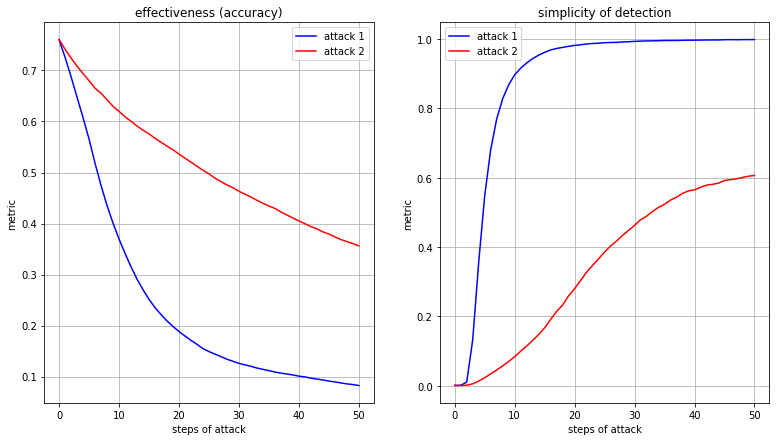

In [15]:
alpha = 10
eps = 0.0056 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]

models_for_viz = {
    'attack 1': ('results/Ford_A/IFGSM/Regular_Disc/Diff_disc/', 0),
    'attack 2': ('results/Ford_A/IFGSM/Regular/', 0),
    }


style ={
    'attack 1':  {'linestyle':'solid', 'linewidth':1.5, 'color':'blue'},
    'attack 2': {'linestyle':'solid', 'linewidth':1.5, 'color':'red'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps)

# DeepFool

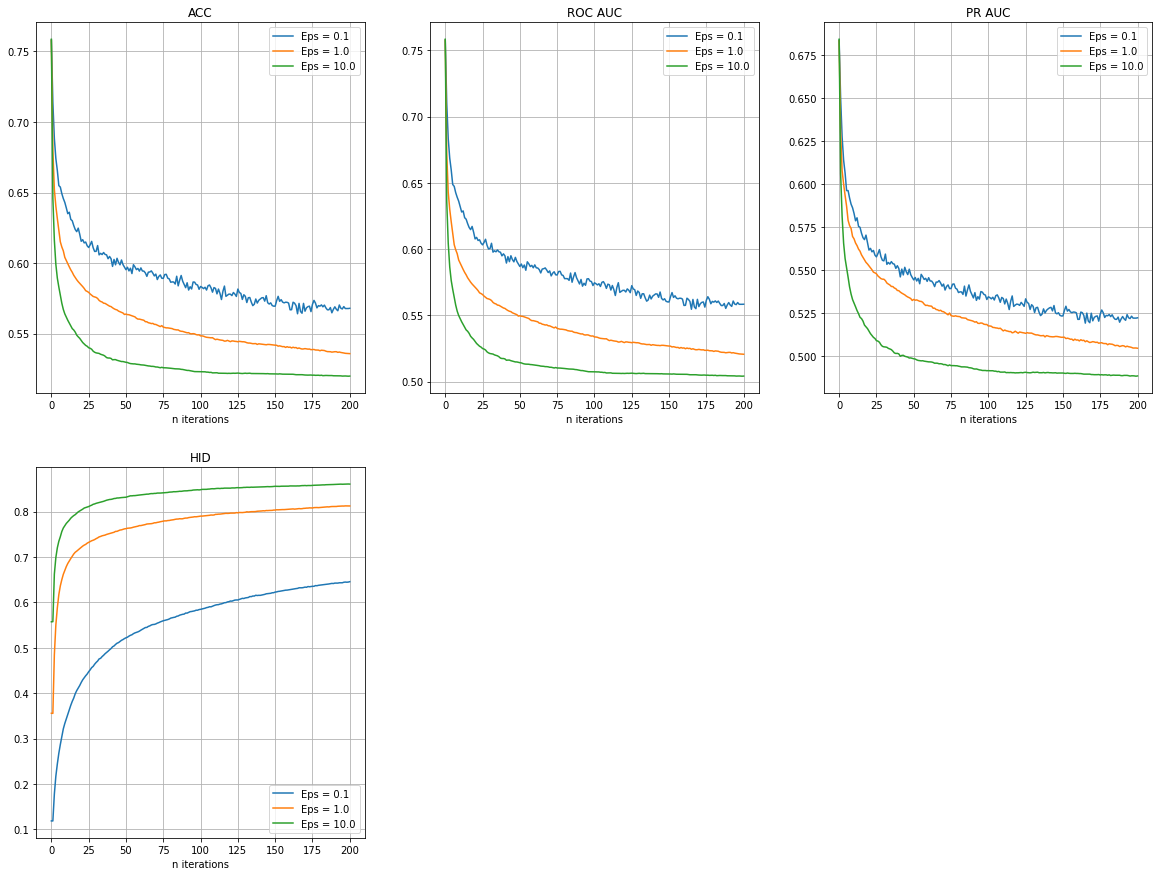

In [ ]:
aa_res_df= pd.read_csv(f'results/Ford_A/DeepFool/Original/aa_res_Ford_A_0_alpha=10.csv', index_col=0)
plot_aa_metrics(aa_res_df, method='metric', metrics=[])

# SimBA

In [ ]:
models_for_viz = {
    'original': ('results/Ford_A/SimBA/Original/', 0),
    'reg_neigh': ('results/Ford_A/SimBA/Regular/', 0),
    'reg_disc_diff_many':('results/Ford_A/SimBA/Regular_Disc_diff_many/', 0),
}

df_res = load_all_datasets(models_for_viz)

Fail with Alpha 0 simba
Fail with Alpha 0.001 simba
Fail with Alpha 0.01 simba
Fail with Alpha 0.1 simba
Fail with Alpha 1 simba
Fail with Alpha 10 simba
Fail with Alpha 100 simba
Fail with Alpha 0 reg_neigh
Fail with Alpha 100 reg_neigh
Fail with Alpha 0 reg_disc_diff_many


In [ ]:
alpha = 1
eps = df_res.eps.unique()[3]
print('eps: ', eps)
mask_alpha_eps = (df_res['eps'] == eps) & (df_res['alpha'].isin([0, alpha]))

df_filter = df_res[mask_alpha_eps]
df_filter

eps:  0.1778279410038923


,n steps,ACC,ROC AUC,PR AUC,HID,eps,method_attack,alpha
0,0,0.760606,0.760334,0.686418,0.477916,0.177828,reg_neigh,1.0
1,1,0.760303,0.760022,0.686133,0.477042,0.177828,reg_neigh,1.0
2,2,0.758561,0.758149,0.684759,0.731079,0.177828,reg_neigh,1.0
3,3,0.752121,0.751667,0.678126,0.841884,0.177828,reg_neigh,1.0
4,4,0.748636,0.748329,0.674010,0.907068,0.177828,reg_neigh,1.0
...,...,...,...,...,...,...,...,...
46,46,0.574924,0.572812,0.526795,0.997965,0.177828,reg_disc_diff_many,1.0
47,47,0.571667,0.569582,0.524619,0.997963,0.177828,reg_disc_diff_many,1.0
48,48,0.570076,0.568055,0.523580,0.998031,0.177828,reg_disc_diff_many,1.0
49,49,0.568864,0.566851,0.522782,0.998081,0.177828,reg_disc_diff_many,1.0


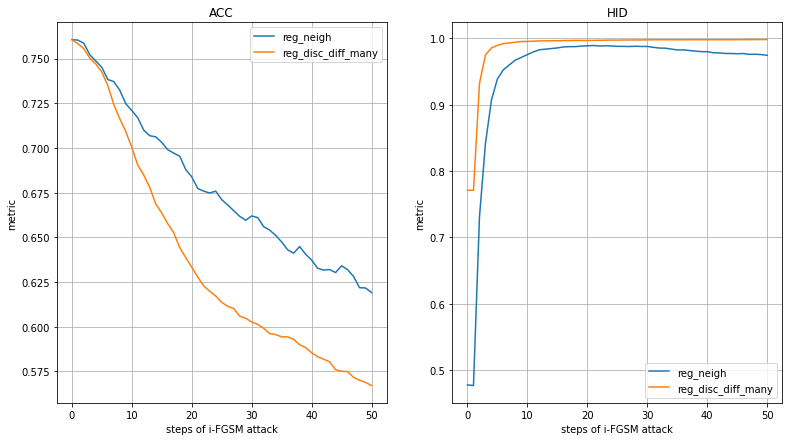

In [ ]:
metrics = ['ACC', 'HID']

plt.figure(figsize=(5*len(metrics) + 3, 7))


for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()


# Coffee

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.001 reg_neigh
Fail with Alpha 0.01 reg_neigh
Fail with Alpha 0 reg_disc_same
Fail with Alpha 0.001 reg_disc_same
Fail with Alpha 0.01 reg_disc_same


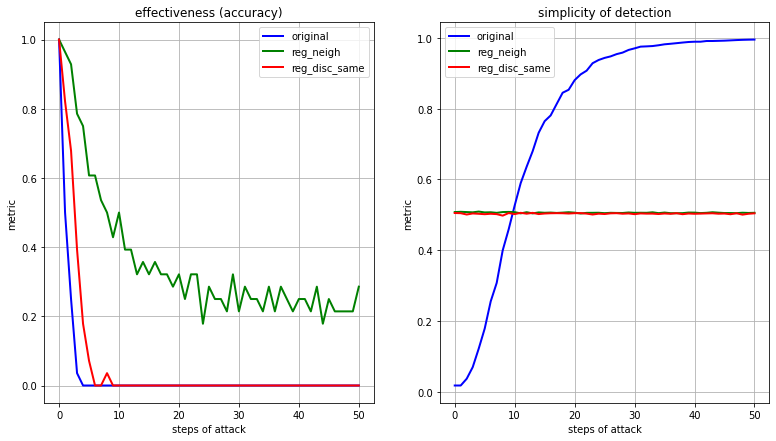

In [7]:
alpha = 100
eps = 0.1778 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'Coffee'


models_for_viz = {
    'original': ('results/Coffee/IFGSM/Original_test_3/', 0),
    'reg_neigh': ('results/Coffee/IFGSM/Reg_test/', 0),
    'reg_disc_same': ('results/Coffee/IFGSM/Disc_reg_test/', 0),
    }


style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh':{'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
    'reg_disc_same':{'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# Strawberry

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.001 reg_neigh
Fail with Alpha 0.01 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc


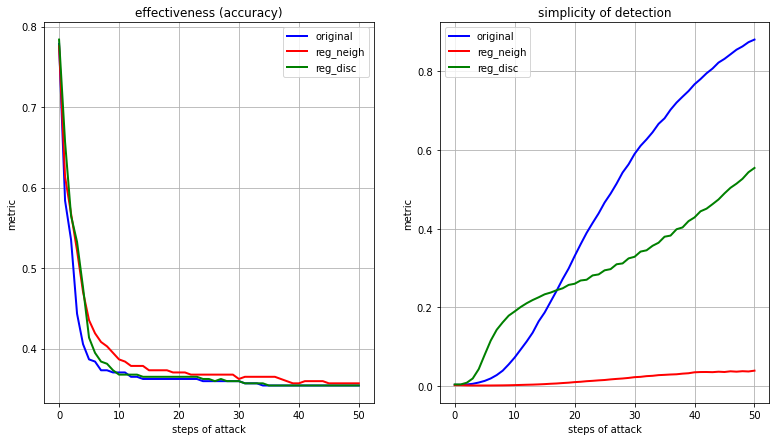

In [92]:
alpha = 10
eps = 0.0316 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'Strawberry'

models_for_viz = {
    #'original': (f'results/{dataset}/IFGSM/Original/', 0),
    'original': (f'results/{dataset}/IFGSM/Original_test_3/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/Regular_test_3/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/Regular_disc_test_3/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# FordA TS2vec

Fail with Alpha 0 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.001 reg_disc
Fail with Alpha 0.01 reg_disc
Fail with Alpha 0.1 reg_disc
Fail with Alpha 100 reg_disc


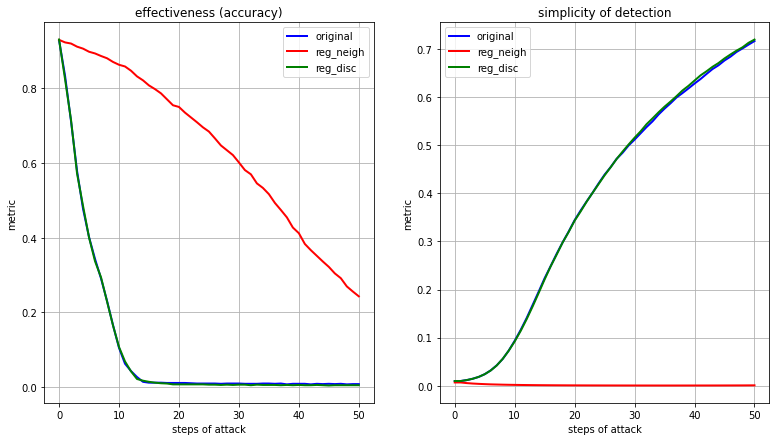

In [5]:
alpha = 10
eps =  0.0316 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'FordA'

models_for_viz = {
    'original': (f'results/{dataset}/IFGSM/New_fgsm_attack/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/New_fgsm_reg_attack/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/Debug_fgsm_disc_attack/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

# FordB

Fail with Alpha 0 reg_neigh
Fail with Alpha 0.01 reg_neigh
Fail with Alpha 0 reg_disc
Fail with Alpha 0.01 reg_disc


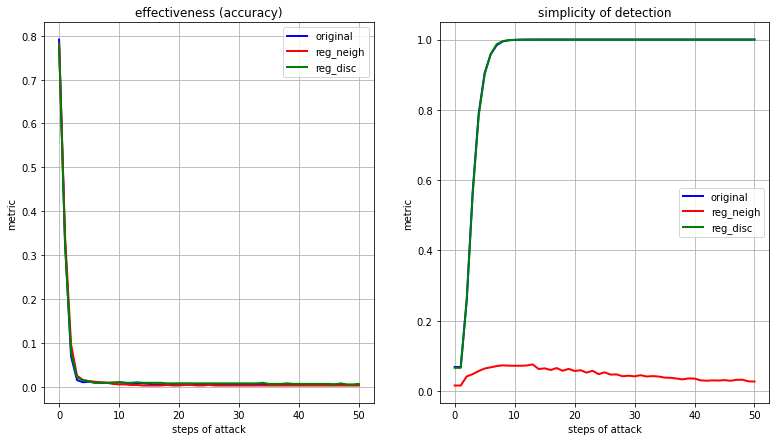

In [91]:
alpha = 0.1
eps = 0.1778 # [0.001, 0.0056, 0.0316, 0.1778, 1.0]
dataset = 'FordB'

models_for_viz = {
    #'original': (f'results/{dataset}/IFGSM/Original/', 0),
    'original': (f'results/{dataset}/IFGSM/Original/', 0),
    'reg_neigh': (f'results/{dataset}/IFGSM/Regular/', 0),
    'reg_disc': (f'results/{dataset}/IFGSM/Regular_disc/', 0),
    }

style ={
    'original':{'linestyle':'solid', 'linewidth':2.0, 'color':'blue'},
    'reg_neigh': {'linestyle':'solid', 'linewidth':2.0, 'color':'red'},
    'reg_disc': {'linestyle':'solid', 'linewidth':2.0, 'color':'green'},
}

plot_attack(models_for_viz=models_for_viz, style=style, alpha=alpha, eps=eps, dataset=dataset)

## Hidennes of adversarial attack

In [ ]:
df_res.eps.unique()[[1]]

array([0.0056])

reg_disc_same


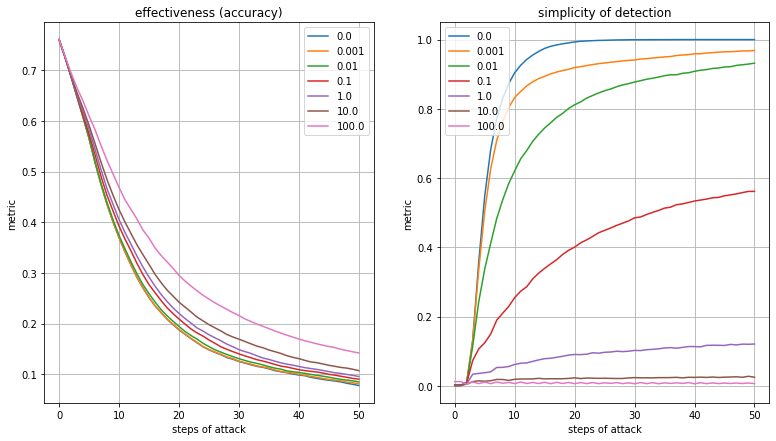

In [ ]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_disc_same', 'original']

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

print(methods[0])

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'effectiveness (accuracy)' if metric == 'ACC' else 'simplicity of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

reg_neigh


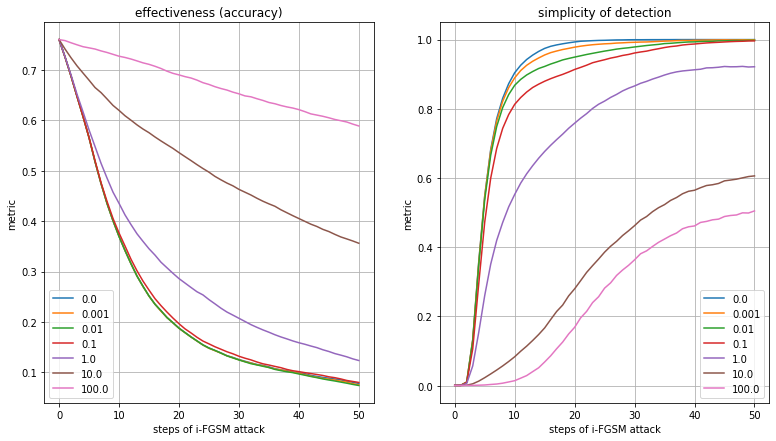

In [ ]:
metrics = ['ACC', 'HID']

eps = df_res.eps.unique()[[1]]
methods = ['reg_neigh', 'original']
print(methods[0])

mask = (df_res['eps'].isin(eps)) & (df_res['method_attack'].isin(methods))

df_filter = df_res[mask]

plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, metric in enumerate(metrics):
    plt.subplot(1, len(metrics), i+1)

    metric_name = 'effectiveness (accuracy)' if metric == 'ACC' else 'simplicity of detection'
    plt.title(metric_name)
    for alpha in sorted(df_filter['alpha'].unique()):
        df_filter_viz = df_filter[df_filter['alpha'] == alpha]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=alpha)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

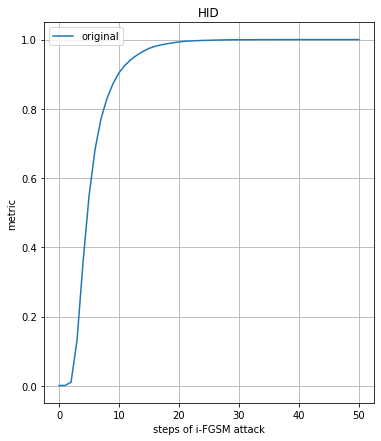

In [ ]:
metrics = ['ACC', 'HID']


plt.figure(figsize=(5*len(metrics) + 3, 7))

for i, alpha in enumerate(df_filter['alpha'].unique()):
    plt.subplot(1, len(metrics), i+1)
    plt.title(metric)
    for method_attack in df_filter['method_attack'].unique():
        df_filter_viz = df_filter[df_filter['method_attack'] == method_attack]
        plt.plot(df_filter_viz['n steps'], df_filter_viz[metric], label=method_attack)

    plt.xlabel('steps of i-FGSM attack')
    plt.ylabel('metric')
    plt.legend()
    plt.grid()
plt.show()

# Data Visualization

In [13]:
import copy
from tqdm.auto import tqdm


import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

from models.models import LSTM_net, TS2VecClassifier
from utils.data import load_Ford_A, transform_data, MyDataset
from utils.attacks import fgsm_attack, fgsm_disc_attack
from utils.config import load_disc_config
from utils.utils import load_disc_model
from utils.TS2Vec.datautils import load_UCR


from utils.discrim_training import HideAttackExp

from utils.attacks import (fgsm_disc_attack, fgsm_attack, fgsm_reg_attack, 
simba_binary, simba_binary_reg, simba_binary_disc_reg, reg_disc)



## load attack params

In [14]:
def fgsm_attack(model, loss_func, x, y_true, eps):

    y_pred = model(x)
    y_pred = y_pred.flatten()

    loss_val = loss_func(y_pred, y_true)

    grad_ = torch.autograd.grad(loss_val, x, retain_graph=True)[0]
    #print('fgsm_grad', torch.linalg.norm(grad_))
    x_adv = x.data + eps * torch.sign(grad_)

    return x_adv


def fgsm_disc_attack(model, loss_func, x, y_true, eps, alpha, disc_models):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    
    loss_val = loss_func(y_pred, y_true)
    grad_loss = torch.autograd.grad(loss_val, x, retain_graph=True)[0]


    reg_value = reg_disc(x, alpha, disc_models)
    grad_reg = torch.autograd.grad(reg_value, x, retain_graph=True)[0]
    grad_ = grad_loss - grad_reg
    x_adv = x.data + eps * torch.sign(grad_)

    return x_adv

def fgsm_reg_attack(model, loss_func, x, y_true, eps, alpha):

    y_pred = model(x)
    y_pred = y_pred.flatten()
    loss_val = loss_func(y_pred, y_true)
    reg_value = reg_neigh(x, alpha)

    loss = loss_val - reg_value
    grad_ = torch.autograd.grad(loss, x, retain_graph=True)[0]
    x_adv = x.data + eps * (torch.sign(grad_))

    return x_adv

def reg_neigh(x, alpha):
            
    x.requires_grad = True
    x_anchor = x[:, 1:-1]
    x_left = x[:, 2:]
    x_right = x[:, :-2]
    x_regular = (x_left + x_right) / 2
    reg_value = torch.sum((x_anchor - x_regular.detach()) ** 2, dim=list(range(1, len(x.shape))))
    reg_value = alpha * torch.mean(reg_value)
    return reg_value


def reg_disc(x, alpha: float, disc_models):
    n_models = len(disc_models)
    reg_value = 0
    for d_model in disc_models:

        # x.grad = None
        # x.requires_grad = True
        req_grad(d_model, state=False)
        #d_model.train(True)
        pred_ = torch.mean(torch.log(F.sigmoid(d_model(x))))
        reg_value = reg_value + pred_

    reg_value = alpha* reg_value / n_models
    return reg_value

def req_grad(model, state: bool = True) -> None:
    for param in model.parameters():
        param.requires_grad_(state)

## TS2Vec

In [15]:
dataset_name = 'FordA'

cfg = {
    'model_folder':f'checkpoints/TS2Vec/entire_model/UCR/{dataset_name}/',
    'model_id_attack': 0,
    'disc_path': f'results/{dataset_name}/IFGSM/Discriminator_pickle',
    'disc_check_params': {'model_id' : 0, 'model_name': 'fgsm_attack_new_eps=0.13_nsteps=10'},

    'list_reg_model_params': [
        {'model_id':0, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.0001_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_new_eps=0.13_alpha=0.001_nsteps=10'},
    ]
}

X_train, y_train, X_test, y_test = load_UCR(dataset_name)
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=False)

device = 'cuda:1'
loss_func = torch.nn.BCELoss()

attack_model = TS2VecClassifier(dropout = 'None').to(device)
disc_model = TS2VecClassifier(dropout=0.0, device=2, n_layers=2).to(device)
disc_model.eval()

model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_{dataset_name}.pth'
attack_model.load_state_dict(copy.deepcopy(torch.load(model_path)))
attack_model.eval()

discriminator = load_disc_model(
        copy.deepcopy(disc_model),
        model_id=cfg['disc_check_params']['model_id'], 
        path=cfg['disc_path'], 
        model_name=cfg['disc_check_params']['model_name'], 
        device=device
        )
discriminator.eval()

index = 15
original_object = X_test[index].unsqueeze(0)
plt.plot(original_object[0])

x = copy.deepcopy(original_object).unsqueeze(-1).to(device)
y = y_test[index].unsqueeze(0).to(torch.float).to(device)

disc_model = TS2VecClassifier(dropout=0.0, device=2, n_layers=2).to(device)
disc_models = load_disc_config(copy.deepcopy(disc_model), cfg['disc_path'], device, cfg['list_reg_model_params'])  
disc_moodels = [model.eval() for model in disc_models]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 2; 15.78 GiB total capacity; 1.18 MiB already allocated; 3.00 MiB free; 2.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

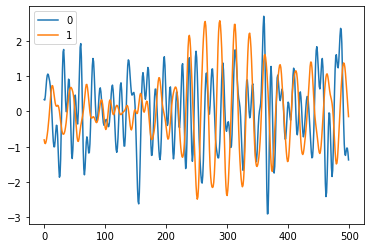

In [ ]:
original_object = X_test[index].unsqueeze(0)
plt.plot(X_test[1].unsqueeze(0)[0], label='0')
plt.plot(X_test[25].unsqueeze(0)[0], label='1')
plt.legend()

In [ ]:
def plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator, iter_='', window=50):

        plt.figure(figsize=(18, 6))
        plt.title(str(iter_))
        label = y.item()
        hid_orig = round(discriminator(x).item(), 3)

        pred = round(attack_model(x_attack).item(), 3)
        hid_pred = round(discriminator(x_attack).item(), 3)
        plt.subplot(1, 3, 1)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.xlabel('Original attack')
        plt.grid()

        plt.subplot(1, 3, 2)

        pred = round(attack_model(x_reg_attack).item(), 3)
        hid_pred = round(discriminator(x_reg_attack).item(), 3)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_reg_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.grid()
        plt.xlabel('Regularized neighbour attack')

        plt.subplot(1, 3, 3)
        pred = round(attack_model(x_disc_attack).item(), 3)
        hid_pred = round(discriminator(x_disc_attack).item(), 3)
        plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
        plt.plot(x_disc_attack.cpu().detach().flatten()[:window], 
                label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
        plt.legend()
        plt.grid()
        plt.xlabel('Regularized discriminator attack')

        plt.show()

In [ ]:
n_iterations = 10
eps = 0.13
alpha = 0.001

x_attack = copy.deepcopy(x)
x_reg_attack = copy.deepcopy(x)
x_disc_attack = copy.deepcopy(x)

for iter_ in tqdm(range(n_iterations)):
    #print(iter_)
    x_attack.grad = None
    x_attack.requires_grad = True

    x_reg_attack.grad = None
    x_reg_attack.requires_grad = True

    x_disc_attack.grad = None
    x_disc_attack.requires_grad = True

    x_attack = fgsm_attack(attack_model, loss_func, x_attack, y, eps)
    x_reg_attack = fgsm_reg_attack(attack_model, loss_func, x_reg_attack, y, eps, alpha)
    x_disc_attack = fgsm_disc_attack(attack_model, loss_func, x_disc_attack, y, eps, alpha, disc_models)

    # if iter_ % 5 == 0:
    #     plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator, iter_=iter_)

NameError: name 'x' is not defined

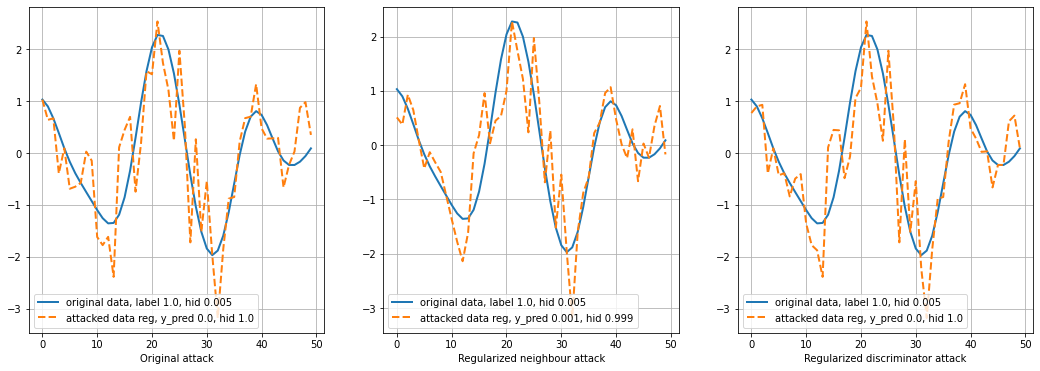

In [ ]:
plot_attack(original_object, x_attack, x_reg_attack, x_disc_attack, y, attack_model, discriminator)

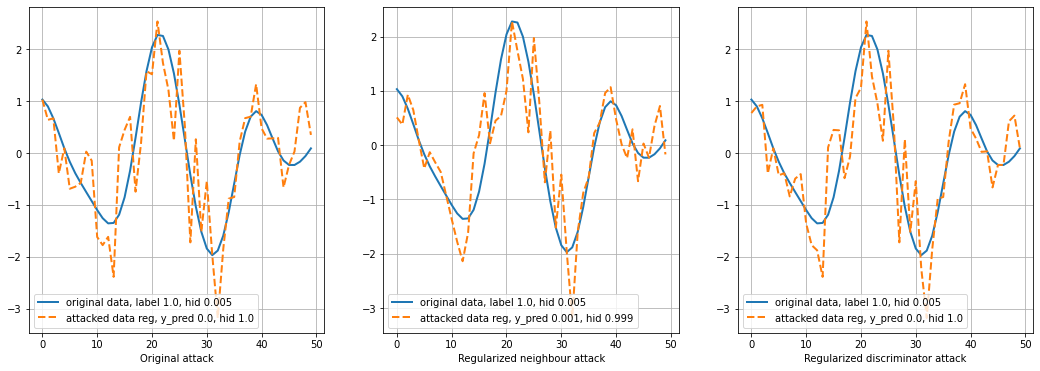

In [23]:
plt.figure(figsize=(18, 6))

window = 50
label = y.item()
hid_orig = round(discriminator(x).item(), 3)

plt.subplot(1, 3, 1)

pred = round(attack_model(x_attack).item(), 3)
hid_pred = round(discriminator(x_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.xlabel('Original attack')
plt.grid()

plt.subplot(1, 3, 2)

pred = round(attack_model(x_reg_attack).item(), 3)
hid_pred = round(discriminator(x_reg_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized neighbour attack')

plt.subplot(1, 3, 3)
pred = round(attack_model(x_disc_attack).item(), 3)
hid_pred = round(discriminator(x_disc_attack).item(), 3)
plt.plot(original_object[0][:window], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten()[:window], 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized discriminator attack')


plt.show()

## Ford_A, LSTM

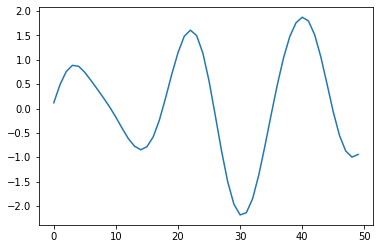

In [35]:
cfg = {
    'model_folder':'checkpoints/LSTM/Ford_A/',
    'model_id_attack': 0,
    'disc_path': 'results/Ford_A/IFGSM/Discriminator_pickle',
    'list_reg_model_params': [
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_reg_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.01_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack_eps=0.03_alpha=0.1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10'},
        {'model_id':2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10'},
     ],
    'disc_check_params': {'model_id' : 0, 'model_name': 'fgsm_attack_eps=0.03_nsteps=10'}
}

dataset_name = 'Ford_A'

X_train, X_test, y_train, y_test = load_Ford_A()
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test)

device = 'cuda:1'
loss_func = torch.nn.BCELoss()

model = LSTM_net(hidden_dim = 50, n_layers = 1, output_dim = 1, dropout=0.0).to(device)
model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_Ford_A.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

discriminator = load_disc_model(
        copy.deepcopy(model),
        model_id=cfg['disc_check_params']['model_id'], 
        path=cfg['disc_path'], 
        model_name=cfg['disc_check_params']['model_name'], 
        device=device
        )


index = 100
original_object = X_test[index].unsqueeze(0)
plt.plot(original_object[0])

x = copy.deepcopy(original_object).unsqueeze(-1).to(device)
y = y_test[index].to(torch.float).to(device)
eps = 0.008
alpha = 10.0

disc_models = load_disc_config(copy.deepcopy(model), cfg['disc_path'], device, cfg['list_reg_model_params'])  

In [36]:
y, model(x), discriminator(x)

(tensor([1.], device='cuda:1'),
 tensor([[0.9695]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[2.0314e-07]], device='cuda:1', grad_fn=<SigmoidBackward0>))

In [41]:
n_iterations = 50

x_attack = copy.deepcopy(x)
x_reg_attack = copy.deepcopy(x)
x_disc_attack = copy.deepcopy(x)

for iter_ in tqdm(range(n_iterations)):
    #print(iter_)
    x_attack.grad = None
    x_attack.requires_grad = True

    x_reg_attack.grad = None
    x_reg_attack.requires_grad = True

    x_disc_attack.grad = None
    x_disc_attack.requires_grad = True

    x_attack = fgsm_attack(model, loss_func, x_attack, y, eps)
    x_reg_attack = fgsm_reg_attack(model, loss_func, x_reg_attack, y, eps, alpha)
    x_disc_attack = fgsm_disc_attack(model, loss_func, x_disc_attack, y, eps, alpha, disc_models)

    # print(iter_, (x_attack == x_disc_attack).all())
    # print(iter_, torch.linalg.norm(x_attack - x_disc_attack))


  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.

In [261]:
y, model(x), model(x_attack), model(x_reg_attack), model(x_disc_attack)

(tensor([1.], device='cuda:1'),
 tensor([[0.9695]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0013]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.9251]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0321]], device='cuda:1', grad_fn=<SigmoidBackward0>))

In [262]:
y, discriminator(x), discriminator(x_attack), discriminator(x_reg_attack), discriminator(x_disc_attack)

(tensor([1.], device='cuda:1'),
 tensor([[2.0314e-07]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[1.0000]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.9999]], device='cuda:1', grad_fn=<SigmoidBackward0>),
 tensor([[0.0005]], device='cuda:1', grad_fn=<SigmoidBackward0>))

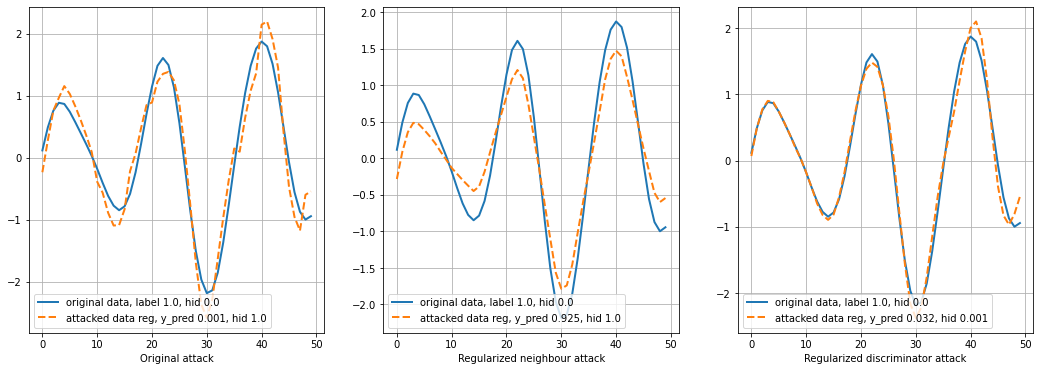

In [270]:
plt.figure(figsize=(18, 6))

label = y.item()
hid_orig = round(discriminator(x).item(), 3)

plt.subplot(1, 3, 1)

pred = round(model(x_attack).item(), 3)
hid_pred = round(discriminator(x_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.xlabel('Original attack')
plt.grid()

plt.subplot(1, 3, 2)

pred = round(model(x_reg_attack).item(), 3)
hid_pred = round(discriminator(x_reg_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_reg_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized neighbour attack')

plt.subplot(1, 3, 3)
pred = round(model(x_disc_attack).item(), 3)
hid_pred = round(discriminator(x_disc_attack).item(), 3)
plt.plot(original_object[0], label=f'original data, label {label}, hid {hid_orig}', lw=2)
plt.plot(x_disc_attack.cpu().detach().flatten(), 
         label=f'attacked data reg, y_pred {pred}, hid {hid_pred}', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.xlabel('Regularized discriminator attack')


plt.show()

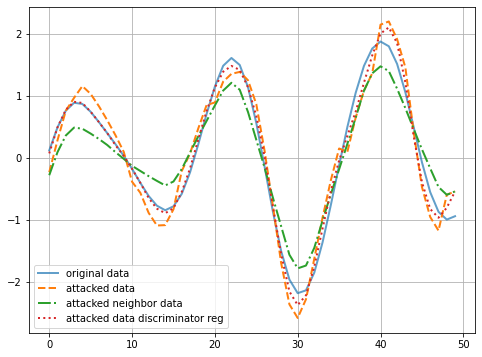

In [271]:
plt.figure(figsize=(8, 6))

plt.plot(original_object[0], label='original data', lw=2, alpha=0.7)
plt.plot(x_attack.cpu().detach().flatten(), label='attacked data', lw=2, linestyle='--')
plt.plot(x_reg_attack.cpu().detach().flatten(), label='attacked neighbor data ',lw=2, linestyle='dashdot')
plt.plot(x_disc_attack.cpu().detach().flatten(), label='attacked data discriminator reg', lw=2, linestyle=':')
plt.legend()
plt.grid()

plt.show()

tensor([0.], device='cuda:1')